# Exploring FEMA natural disaster data

We are examining natural hazard data found on the FEMA website here: https://www.fema.gov/openfema-dataset-disaster-declarations-summaries-v1

Let's focus on answering these main questions:
- What are the most frequent disaster types?
- What are the most severe disaster types?

We can get started by importing the libraries we are going to need.

In [186]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

sns.set_style('darkgrid')
%matplotlib inline

Now we can import the csv file as a dataframe

In [187]:
df = pd.read_csv('DisasterDeclarationsSummaries.csv')
df.head()

,disasterNumber,ihProgramDeclared,iaProgramDeclared,paProgramDeclared,hmProgramDeclared,state,declarationDate,fyDeclared,disasterType,incidentType,title,incidentBeginDate,incidentEndDate,disasterCloseOutDate,declaredCountyArea,placeCode,hash,lastRefresh
0,1,0,1,1,1,GA,1953-05-02T00:00:00.000Z,1953,DR,Tornado,TORNADO,1953-05-02T00:00:00.000Z,1953-05-02T00:00:00.000Z,1954-06-01T00:00:00.000Z,NaN,NaN,1dcb40d0664d22d39de787b706b0fa69,2019-07-26T18:08:57.368Z
1,2,0,1,1,1,TX,1953-05-15T00:00:00.000Z,1953,DR,Tornado,TORNADO & HEAVY RAINFALL,1953-05-15T00:00:00.000Z,1953-05-15T00:00:00.000Z,1958-01-01T00:00:00.000Z,NaN,NaN,61612cea5779e361b429799098974b6a,2019-07-26T18:08:57.370Z
2,3,0,1,1,1,LA,1953-05-29T00:00:00.000Z,1953,DR,Flood,FLOOD,1953-05-29T00:00:00.000Z,1953-05-29T00:00:00.000Z,1960-02-01T00:00:00.000Z,NaN,NaN,86f3e47785cb7acc51364d4535d36101,2019-07-26T18:08:57.369Z
3,6,0,1,1,1,MI,1953-06-09T00:00:00.000Z,1953,DR,Tornado,TORNADO,1953-06-09T00:00:00.000Z,1953-06-09T00:00:00.000Z,1956-03-30T00:00:00.000Z,NaN,NaN,2208518c84c44f8e4164248d47f89ead,2019-07-26T18:08:57.369Z
4,4,0,1,1,1,MI,1953-06-02T00:00:00.000Z,1953,DR,Tornado,TORNADO,1953-06-02T00:00:00.000Z,1953-06-02T00:00:00.000Z,1956-02-01T00:00:00.000Z,NaN,NaN,1dbe5937a01fc74c8e699912e3f555cb,2019-07-26T18:08:57.370Z


## Determining most frequent disaster types

The disaster frequency was determined by grouping by unique values of `disasterNumber` and `incidentType`. `disasterNumber` was then renamed to `frequency` to appropriately reflect what it is representing. 

In [188]:
disaster_frequency = df.groupby('incidentType')['disasterNumber'].nunique().reset_index()
disaster_frequency = disaster_frequency.sort_values(ascending=False, by='disasterNumber')

disaster_frequency.rename(columns = {'disasterNumber': 'frequency'}, inplace = True) 
disaster_frequency.head()

,incidentType,frequency
5,Fire,1124
14,Severe Storm(s),962
7,Flood,831
10,Hurricane,368
17,Tornado,167


We can clearly see from the table above that fire is the most frequent disaster type. To make it simpler, we can also see this visually. Only the top 10 disaster types by frequency were plotted.

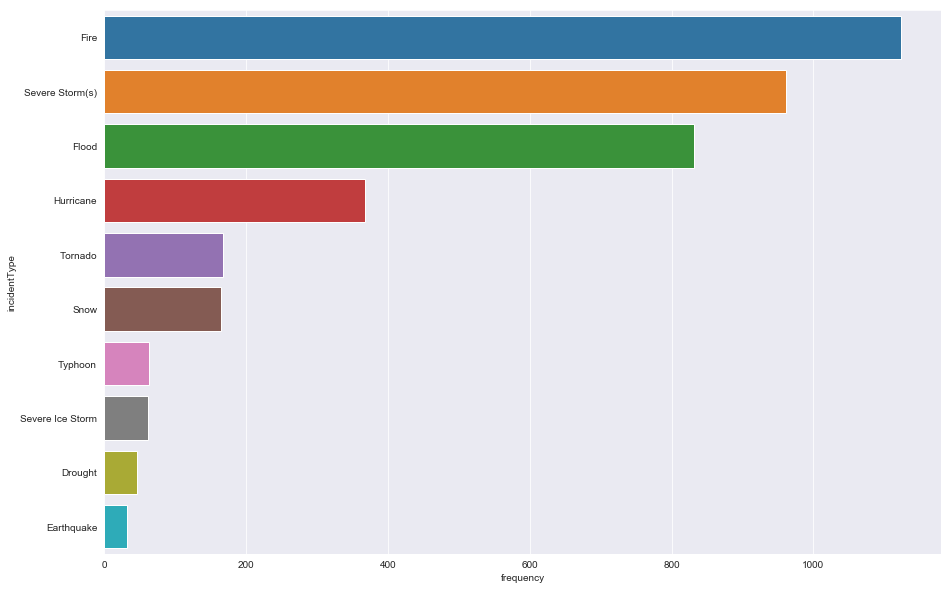

In [190]:
sns.barplot(data=disaster_frequency.head(n=10), x='frequency', y='incidentType')
plt.rcParams['figure.figsize'] = [15, 10]

We can also see the frequency of disasters over time utilizing the groupby function.

In [191]:
frequency_year = df.groupby(['incidentType', 'fyDeclared'])['disasterNumber'].nunique().reset_index()
frequency_year.rename(columns = {'disasterNumber': 'frequency'}, inplace = True)

We will also create a Series of the most frequent disaster types that we will be able to reference later when plotting.

In [192]:
most_frequent = disaster_frequency.head(n=6)
most_frequent = most_frequent['incidentType']
most_frequent.head()

5                Fire
14    Severe Storm(s)
7               Flood
10          Hurricane
17            Tornado
Name: incidentType, dtype: object

Now we can plot disaster frequency over time

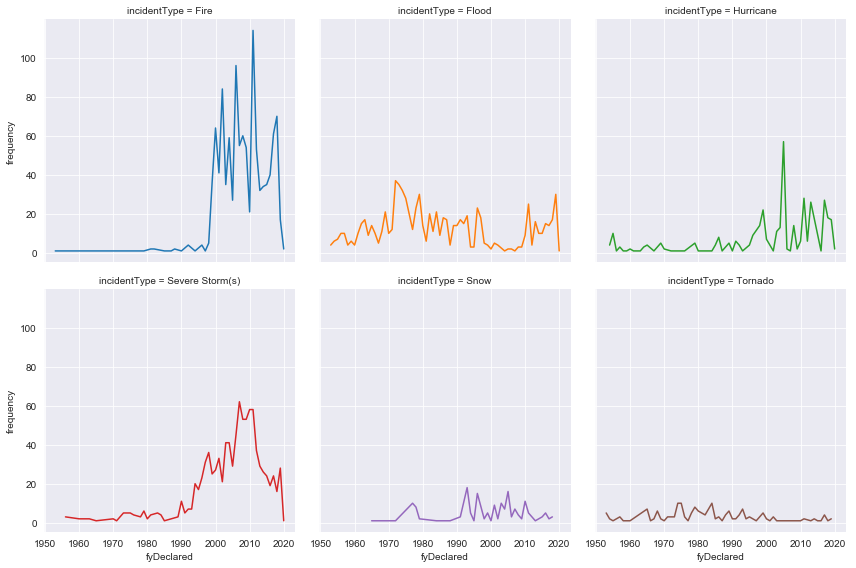

In [193]:
def lineplot(data, x, y, hue, title=None):
    temp = data[hue].isin(most_frequent)
    data = data[temp]
    g = sns.FacetGrid(data=data, col=hue, col_wrap=3, hue=hue, height=4)
    g.map(sns.lineplot, x, y)
    
lineplot(data=frequency_year, x='fyDeclared', y='frequency', hue='incidentType')

It is interesting to note how drastically frequency of fires increased around the year 2000. The sharp increase indicates that this data may not have been tracked prior to the year 2000. This also suggests that overall data quality may be lacking before 2000. However, you can still clearly see that fire is by far the most frequent incident type, even when nearly all of the data recorded was after 2000. This was enough to surpass other disasters types that exhibited more consistent trends throughout.

## Determining most severe disaster types


We are going to focus this section on the top disaster types that were plotted in the previously:

- Fire      
- Severe storm
- Snow      
- Tornado
- Flood     
- Hurricane

In order to indicate the magnitude of a disaster, we can groupby the occurrences of `disasterNumber`. This is then stored in a new column, `count`. The more a particular `disasterNumber` repeated, the more severe and widespread it was. In order for this to work properly, we also need to drop unnecessary columns from the dataframe.

In [194]:
df = df.drop(['ihProgramDeclared', 'iaProgramDeclared',
       'paProgramDeclared', 'hmProgramDeclared', 'declarationDate','disasterType',
       'disasterCloseOutDate','declaredCountyArea', 'placeCode', 'hash', 'lastRefresh'], axis=1)

In [195]:
df = df.groupby(list(df.columns)).size().reset_index().rename(columns={0:'count'})
df.head()

,disasterNumber,state,fyDeclared,incidentType,title,incidentBeginDate,incidentEndDate,count
0,1,GA,1953,Tornado,TORNADO,1953-05-02T00:00:00.000Z,1953-05-02T00:00:00.000Z,1
1,2,TX,1953,Tornado,TORNADO & HEAVY RAINFALL,1953-05-15T00:00:00.000Z,1953-05-15T00:00:00.000Z,1
2,3,LA,1953,Flood,FLOOD,1953-05-29T00:00:00.000Z,1953-05-29T00:00:00.000Z,1
3,4,MI,1953,Tornado,TORNADO,1953-06-02T00:00:00.000Z,1953-06-02T00:00:00.000Z,1
4,5,MT,1953,Flood,FLOODS,1953-06-06T00:00:00.000Z,1953-06-06T00:00:00.000Z,1


To take it a step further, we can also create another custom metric for severity. To indicate the magnitude of an incident over time, `durationDays` was created. This column will be used when creating the custom metric.

In [196]:
df['incidentBeginDate'] = pd.to_datetime(df['incidentBeginDate'])
df['incidentEndDate'] = pd.to_datetime(df['incidentEndDate'])
new_col = (df['incidentEndDate'] - df['incidentBeginDate']).dt.days
df.insert(7, 'durationDays', new_col)
df.head()

,disasterNumber,state,fyDeclared,incidentType,title,incidentBeginDate,incidentEndDate,durationDays,count
0,1,GA,1953,Tornado,TORNADO,1953-05-02 00:00:00+00:00,1953-05-02 00:00:00+00:00,0,1
1,2,TX,1953,Tornado,TORNADO & HEAVY RAINFALL,1953-05-15 00:00:00+00:00,1953-05-15 00:00:00+00:00,0,1
2,3,LA,1953,Flood,FLOOD,1953-05-29 00:00:00+00:00,1953-05-29 00:00:00+00:00,0,1
3,4,MI,1953,Tornado,TORNADO,1953-06-02 00:00:00+00:00,1953-06-02 00:00:00+00:00,0,1
4,5,MT,1953,Flood,FLOODS,1953-06-06 00:00:00+00:00,1953-06-06 00:00:00+00:00,0,1


We can now create another simple metric of magnitude by dividing `count` by `durationDays`. It is worth noting that upon analyzing the `durationDays` column, that data quality is lacking. There are many occurrences of values that do not make logical sense, such as negatives and extremely high values. To combat the negative values, the absolute value of `durationDays` will be taken so that there are no negative ratings. Additionally, all values of 0 in `durationDays` will be converted to 1 to avoid errors when dividing.

The new column, `rating`, is calculated below

In [197]:
df['durationDays'] += df['durationDays'].eq(0)
df['rating'] = df['count'] / abs(df['durationDays'])
df.head()

,disasterNumber,state,fyDeclared,incidentType,title,incidentBeginDate,incidentEndDate,durationDays,count,rating
0,1,GA,1953,Tornado,TORNADO,1953-05-02 00:00:00+00:00,1953-05-02 00:00:00+00:00,1,1,1.0
1,2,TX,1953,Tornado,TORNADO & HEAVY RAINFALL,1953-05-15 00:00:00+00:00,1953-05-15 00:00:00+00:00,1,1,1.0
2,3,LA,1953,Flood,FLOOD,1953-05-29 00:00:00+00:00,1953-05-29 00:00:00+00:00,1,1,1.0
3,4,MI,1953,Tornado,TORNADO,1953-06-02 00:00:00+00:00,1953-06-02 00:00:00+00:00,1,1,1.0
4,5,MT,1953,Flood,FLOODS,1953-06-06 00:00:00+00:00,1953-06-06 00:00:00+00:00,1,1,1.0


We can see a summary of statistics of the dataframe below

In [198]:
df.describe()

,disasterNumber,fyDeclared,durationDays,count,rating
count,3708.000000,3708.000000,3708.000000,3708.000000,3708.000000
mean,2192.764024,1998.367314,15.401025,13.589806,4.177237
std,1491.606779,16.449084,104.023802,22.514768,9.413946
min,1.000000,1953.000000,-340.000000,1.000000,0.000195
25%,927.750000,1989.000000,1.000000,1.000000,0.333333
50%,1854.500000,2003.000000,4.000000,5.000000,1.000000
75%,3217.250000,2011.000000,14.000000,16.000000,3.717532
max,5286.000000,2020.000000,5117.000000,257.000000,144.000000


We can better visualize the statistics by utilizing box plots.

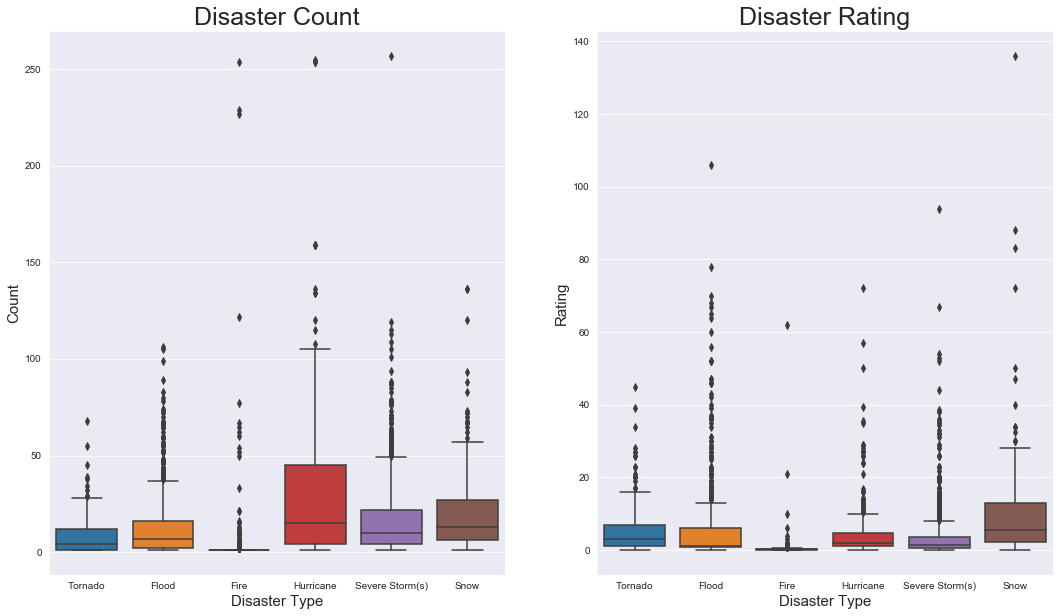

In [199]:
def boxplot(data1, data2, x, y1, y2):
    temp1 = data1[x].isin(most_frequent)
    data1 = data1[temp1]
    temp2 = data2[x].isin(most_frequent)
    data2 = data2[temp2]
    f, axes =  plt.subplots(1, 2, figsize=(18, 10), sharex=True, sharey=False)
    
    sns.boxplot(data=data1, x=x, y=y1, ax=axes[0])
    axes[0].set_title('Disaster ' + y1.capitalize(), fontsize=25)
    axes[0].set_ylabel(y1.capitalize(), fontsize=15)
    axes[0].set_xlabel('Disaster Type', fontsize=15)
    
    sns.boxplot(data=data2, x=x, y=y2, ax=axes[1])
    axes[1].set_title('Disaster ' + y2.capitalize(), fontsize=25)
    axes[1].set_ylabel(y2.capitalize(), fontsize=15)
    axes[1].set_xlabel('Disaster Type', fontsize=15)
    
boxplot(df, df, 'incidentType', 'count', 'rating')

*Note that the two plots above do not share the same y axis*

We can see that both `count` and `rating` are heavily skewed toward lower intensity. The more severe disasters are reflected here as outliers. Since we know that data quality may be an issue here, we can create new dataframes to remove outliers to get a better scope of the overall picture. Values 3 standard deviations from the mean were removed below.

In [200]:
df = df.apply(pd.to_numeric, errors='ignore')
rating_outliers = df[(np.abs(stats.zscore(df['rating'])) < 3)]
count_outliers = df[(np.abs(stats.zscore(df['count'])) < 3)]

Box plots can now be replotted by reusing the function above.

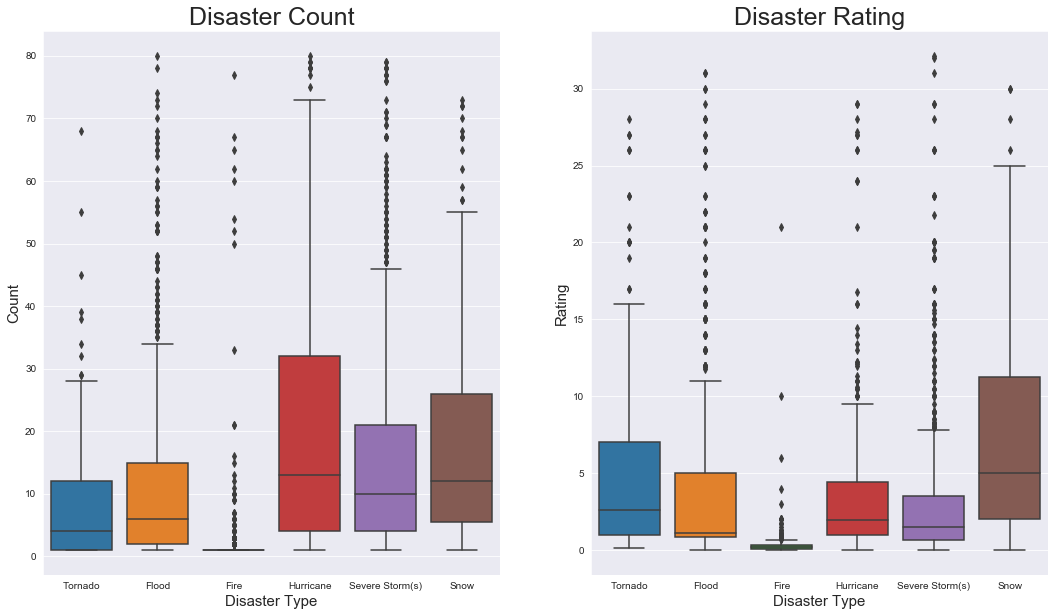

In [201]:
boxplot(count_outliers, rating_outliers, 'incidentType', 'count', 'rating')

We can see that even when excluding the outliers from the original dataframe, outliers still exist. However, we are better able to see the scope of the distribution as a whole as each box plot is more pronounced. This further exemplifies how the data is skewed toward less extreme incidents.

Fire is perhaps the most interesting element in the plot. If we remember from earlier, fire was the most frequent disaster type. However, the plot above makes it clear that although fires occurred the most frequently, the average serverity of each was far below that of the other disaster types.

Just like disaster frequency, we can also see how `count` and `rating` have changed over time.

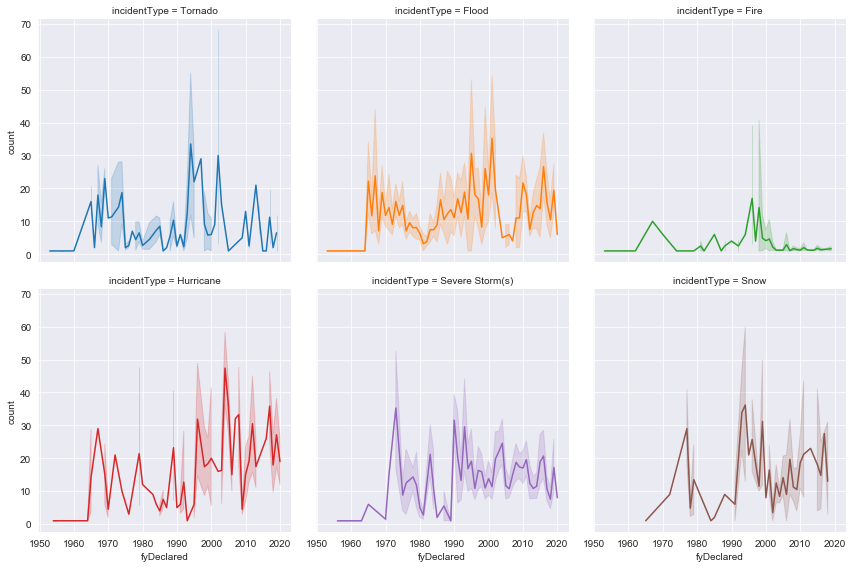

In [202]:
lineplot(count_outliers, 'fyDeclared', 'count', 'incidentType')

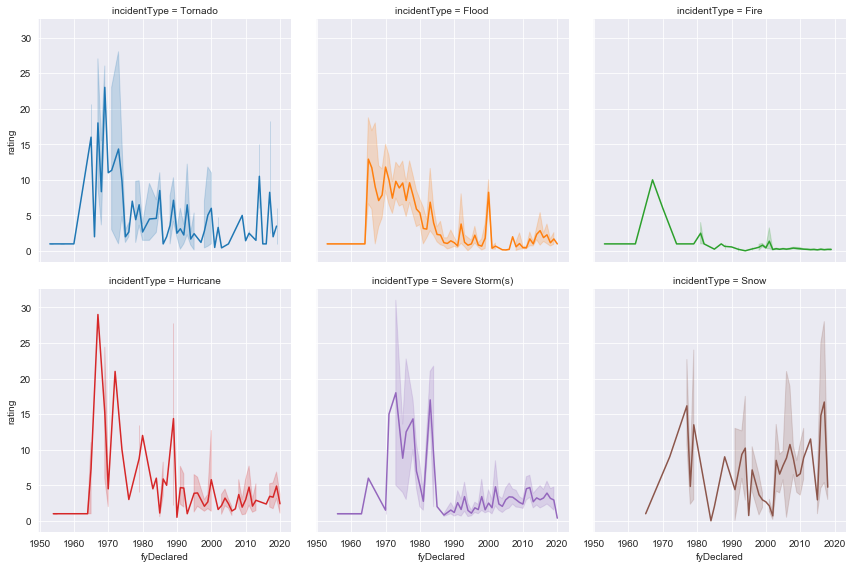

In [203]:
lineplot(rating_outliers, 'fyDeclared', 'rating', 'incidentType')

Since we established that data quality may have been an issue in this dataset, we can create another plot excluding data prior to the year 2000. This was chosen as the cutoff point due to our previous findings of fire frequency when we established that data prior to this time was insufficient.

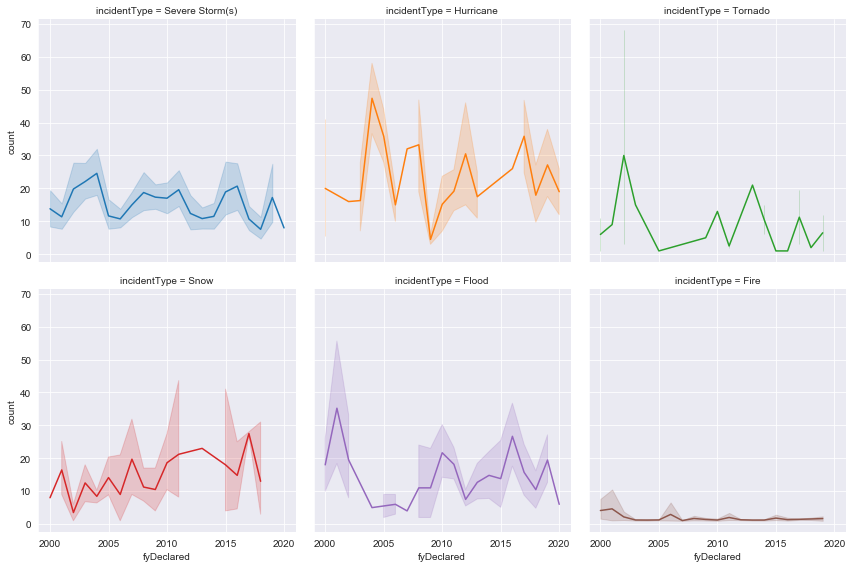

In [204]:
count_2000 = count_outliers['fyDeclared'] >= 2000
count_2000 = count_outliers[count_2000]
lineplot(count_2000, 'fyDeclared', 'count', 'incidentType')

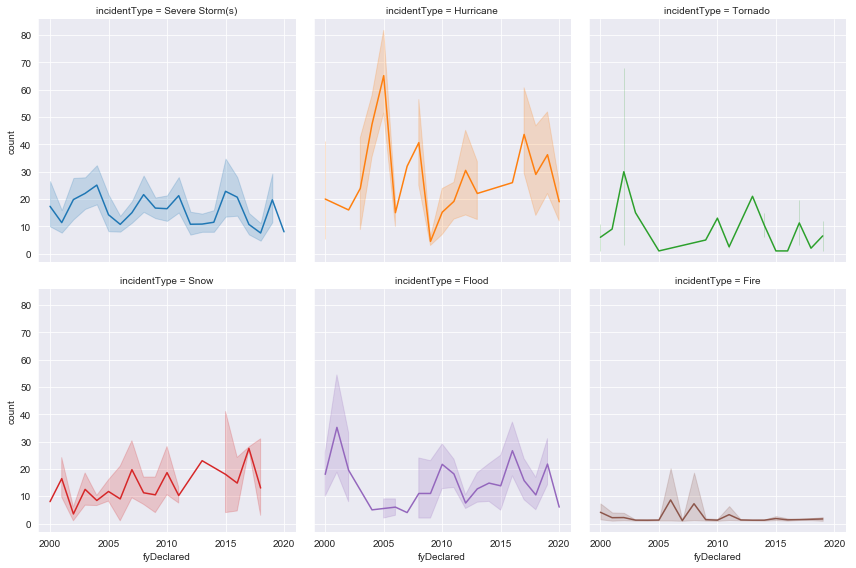

In [205]:
rating_2000 = rating_outliers['fyDeclared'] >= 2000
rating_2000 = rating_outliers[rating_2000]
lineplot(rating_2000, 'fyDeclared', 'count', 'incidentType')

We can now see how `count` and `rating` fluctuate over time. It is evident that although fire is the most frequent incident type, it is the least severe. Hurricanes on the other hand, are the most severe disaster types according to both the `count` and `rating` metrics.